In [4]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
import mylib
from tqdm import tqdm
from importlib import reload
import pymaster as nmt
import scipy as sp
import camb

In [5]:
nside = 128
lmax = 3*nside - 1
npix = 12 * nside**2

input_cls_lcdm = mylib.get_camb(Alens=1, r=0, lmax=lmax)

input_cls_noBB = np.copy(input_cls_lcdm)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls_lcdm)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

In [6]:
mask, weight = mylib.get_weight(nside)
fsky = np.sum(mask)/npix
print(fsky*100)

apo_size = 10
mask_apo = nmt.mask_apodization(weight, apo_size, 'C2')
mask_apo /= np.sqrt(np.mean(mask_apo**2)) 

w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)

R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])
R = ZZ @ R_unapo

pi_b = sp.sparse.load_npz(f'apo{apo_size}/pi_b_5000.npz')

4.40673828125


In [7]:
reload(mylib)
bin_size = 16
b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
l = np.arange(lmax+1)
c2d = l * (l+1) / 2/np.pi
sigmab = hp.nside2resol(nside) 
fwhm = (8*np.log(2))**0.5 * sigmab 
# fwhm = hp.nside2resol(nside)
bl = hp.gauss_beam(fwhm, lmax) 
mll_KS = mylib.get_mll(mask_apo, nside, b, pol=True, purify_b=True)[2::4,2::4]
mll = mylib.get_mll(mask_apo, nside, b, pol=True)[2::4,2::4]
mll_scalar = mylib.get_mll(mask_apo, nside, b)

In [19]:
# #filter transfer
# nmc_transfer = 256

# pcl = np.zeros(lmax+1)
# pcl_pure = np.zeros(lmax+1)
# pcl_KS = np.zeros(lmax+1)
# pcl_scalar = np.zeros(lmax+1)

# for i in tqdm(range(nmc_transfer)):
#     np.random.seed(i+1000)
#     signal = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
#     obs_m_unapo = (R_unapo @ signal.flatten()).reshape(3, npix) 
#     obs_m = mask_apo * obs_m_unapo

#     pcl += hp.anafast(obs_m)[2]

#     f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:], purify_b=True)
#     pcl_KS += nmt.compute_coupled_cell(f, f)[3]

#     B_map_unapo = hp.alm2map(hp.map2alm(obs_m_unapo)[2], nside)
#     pcl_scalar += hp.anafast(mask_apo * B_map_unapo)
    
#     obs_m[1:] = (pi_b @ (obs_m)[1:].flatten()).reshape(2, npix)
#     pcl_pure += hp.anafast(obs_m)[2]
    
# pcl /= nmc_transfer
# pcl_KS /= nmc_transfer
# pcl_scalar /= nmc_transfer
# pcl_pure /= nmc_transfer

# # np.save(f'apo{apo_size}/pcl', pcl)
# # np.save(f'apo{apo_size}/pcl_KS', pcl_KS)
# # np.save(f'apo{apo_size}/pcl_scalar', pcl_scalar)
# # np.save(f'apo{apo_size}/pcl_pure', pcl_pure)

pcl = np.load(f'apo{apo_size}/pcl.npy')
pcl_KS = np.load(f'apo{apo_size}/pcl_KS.npy')
pcl_scalar = np.load(f'apo{apo_size}/pcl_scalar.npy')
pcl_pure = np.load(f'apo{apo_size}/pcl_pure.npy')

In [20]:
# plt.plot(pcl, label='pcl')
# plt.plot(pcl_KS, label='KS')
# plt.plot(pcl_scalar, label='scalar')
# plt.plot(pcl_pure, label='pure')
# # plt.plot(bl**2*mll_KS@input_cls_lcdm[2], label='input BB (masked + beam)')

# plt.xlim([20, 2*nside])
# plt.loglog()
# plt.grid()
# plt.legend()

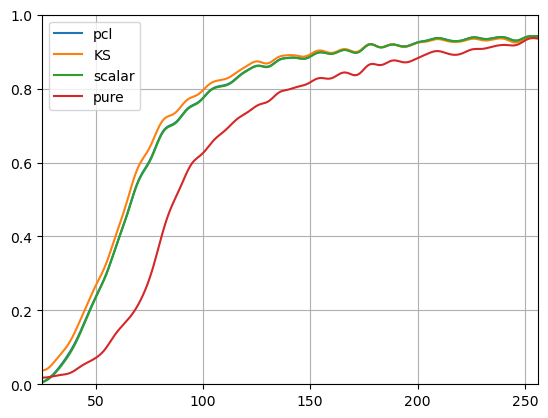

In [26]:
reload(mylib)
fl = mylib.get_fl(pcl, bl, mll, input_cls_lcdm[2], niter=3)
fl_KS = mylib.get_fl(pcl_KS, bl, mll_KS, input_cls_lcdm[2], niter=3)
fl_scalar = np.abs(mylib.get_fl(pcl_scalar, bl, mll_scalar, input_cls_lcdm[2], niter=3))
fl_pure = mylib.get_fl(pcl_pure, bl, mll, input_cls_lcdm[2], niter=3)

plt.plot(fl, label='pcl')
plt.plot(fl_KS, label='KS')
plt.plot(fl_scalar, label='scalar')
plt.plot(fl_pure, label='pure')
plt.xlim([25, 2*nside])
plt.ylim([0,1])
plt.grid()
plt.legend()

In [13]:
w_scalar = nmt.NmtWorkspace()
f_scalar = nmt.NmtField(mask_apo, np.empty((1, npix)), beam=bl*np.sqrt(fl_scalar))
w_scalar.compute_coupling_matrix(f_scalar, f_scalar, b)
bpw_scalar = w_scalar.get_bandpower_windows()[0, :, 0]

w = nmt.NmtWorkspace()
f = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl))
w.compute_coupling_matrix(f, f, b)
bpw = w.get_bandpower_windows()[3, :, 3]

w_pure = nmt.NmtWorkspace()
f_pure = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_pure))
w_pure.compute_coupling_matrix(f_pure, f_pure, b)
bpw_pure = w_pure.get_bandpower_windows()[3, :, 3]

w_KS = nmt.NmtWorkspace()
f_KS = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl_KS), purify_b=True)
w_KS.compute_coupling_matrix(f_KS, f_KS, b)
bpw_KS = w_KS.get_bandpower_windows()[3, :, 3]

In [44]:
prefix='S4'
# prefix='SO_opt'
nmc_noise = 256

# cl_noise = np.zeros((6, lmax+1))
# cl_noise_KS_pol = np.zeros((4, lmax+1))
# cl_noise_scalar = np.zeros(lmax+1)
# cl_noise_pure = np.zeros((6,lmax+1))

# nl_KS = np.zeros((nmc_noise, len(ells)))
# nl_pure = np.zeros((nmc_noise, len(ells)))
# nl_scalar = np.zeros((nmc_noise, len(ells)))
nl = np.zeros((nmc_noise, len(ells)))

# noise_cls = np.array([np.zeros(lmax+1), s4, s4, np.zeros(lmax+1)])
for i in tqdm(range(nmc_noise)):
    obs_noise_unapo = hp.read_map(f'{prefix}/out/{i+1000}/filterbin_filtered_map.fits', field=None)
    obs_noise = mask_apo * obs_noise_unapo
    # np.random.seed(i)
    # noise = hp.synfast(noise_cls, nside, new=True)
    # obs_noise_unapo = (R_unapo @ noise.flatten()).reshape(3, npix) 
    
    # cl_noise += hp.anafast(obs_noise)

    # f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:], purify_b=True)
    # cl_noise_KS_pol += nmt.compute_coupled_cell(f, f)

    # B_map = hp.alm2map(hp.map2alm(obs_noise_unapo)[2], nside)
    # cl_noise_scalar += hp.anafast(mask_apo * B_map_unapo)

#     obs_noise[1:] = (pi_b @ obs_noise[1:].flatten()).reshape(2, npix)
    # cl_noise_pure += hp.anafast(obs_noise)

    f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:])
    nl[i] = nmt.compute_full_master(f, f, b, workspace=w)[3]
    
    # f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:], purify_b=True)
    # nl_KS[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

    # pure_QU = (pi_b @ (obs_noise[1:]).flatten()).reshape(2,npix)
    # f = nmt.NmtField(mask_apo, mask*pure_QU, masked_on_input=True)
    # nl_pure[i] = nmt.compute_full_master(f, f, b, workspace=w_pure)[3]

    # f = nmt.NmtField(mask_apo, mask*[B_map])
    # nl_scalar[i] = nmt.compute_full_master(f, f, b, workspace=w_scalar)[0]

# cl_noise /= nmc_noise
# cl_noise_pol = np.array([cl_noise[1], cl_noise[4], cl_noise[4], cl_noise[2]])
# cl_noise_KS_pol /= nmc_noise
# # # cl_noise_scalar /= nmc_noise
# # cl_noise_pure /= nmc_noise
# # cl_noise_pure_pol = np.array([cl_noise_pure[1], cl_noise_pure[4], cl_noise_pure[4], cl_noise_pure[2]])

mean_nl = np.mean(nl, axis=0)
std_nl = np.std(nl, axis=0)

# mean_nl_KS = np.mean(nl_KS, axis=0)
# std_nl_KS = np.std(nl_KS, axis=0)

# mean_nl_pure = np.mean(nl_pure, axis=0)
# std_nl_pure = np.std(nl_pure, axis=0)

# mean_nl_scalar = np.mean(nl_scalar, axis=0)
# std_nl_scalar = np.std(nl_scalar, axis=0)

# np.save(f'apo{apo_size}/{prefix}_cl_noise_pol', cl_noise_pol)
# np.save(f'apo{apo_size}/{prefix}_cl_noise_KS_pol', cl_noise_KS_pol)
# np.save(f'apo{apo_size}/{prefix}_cl_noise_scalar', cl_noise_scalar)
# np.save(f'apo{apo_size}/{prefix}_cl_noise_pure_pol', cl_noise_pure_pol)

# cl_noise_pol = np.load(f'apo{apo_size}/{prefix}_cl_noise_pol.npy')
# cl_noise_KS_pol = np.load(f'apo{apo_size}/{prefix}_cl_noise_KS_pol.npy')
# cl_noise_scalar = np.load(f'apo{apo_size}/{prefix}_cl_noise_scalar.npy')
# cl_noise_pure_pol = np.load(f'apo{apo_size}/{prefix}_cl_noise_pure_pol.npy')

100%|█████████████████████████████████████████| 256/256 [02:43<00:00,  1.57it/s]


In [45]:
# plt.plot(cl_noise_pol[3])
# plt.plot(cl_noise_KS_pol[3], label='KS')
# # plt.plot(cl_noise_scalar, label='scalar')
# plt.plot(cl_noise_pure_pol[3], label='pure')
# plt.loglog()
# plt.grid()
# plt.legend()
# plt.xlim([2, 2*nside])

In [46]:
#roughly by eye
planck_T_noise_props = [25, 50, -1.8]
planck_P_noise_props = [50, 20, -1.4]
planck_T = mylib.get_Nl(planck_T_noise_props, lmax)
planck_P = mylib.get_Nl(planck_P_noise_props, lmax)
planck_noise_cls = np.array([planck_T, planck_P, planck_P, np.zeros(lmax+1)])

lb_T_noise_props = [1.8, 5, -1] 
lb_P_noise_props = [2.16, 5, -1] 
lb_T = mylib.get_Nl(lb_T_noise_props, lmax)
lb_P = mylib.get_Nl(lb_P_noise_props, lmax)
lb_noise_cls = np.array([lb_T, lb_P, lb_P, np.zeros(lmax+1)])

# # sat_pol_baseline = mylib.get_Nl([np.sqrt(2)*3.3, 50, -3], lmax)
# # sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 25, -3], lmax)
sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 50, -3], lmax)

s4 = mylib.get_Nl([1, 50, -3], lmax)

(1e-05, 0.1)

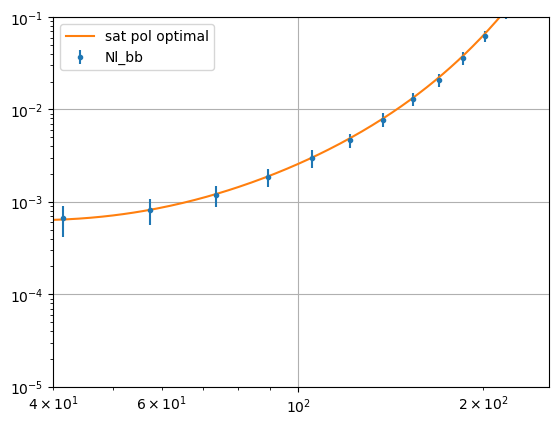

In [43]:
plt.errorbar(ells, c2db*mean_nl, yerr=c2db*std_nl, fmt='.', label='Nl_bb')
# plt.errorbar(ells, c2db*mean_nl_KS, yerr=c2db*std_nl_KS, fmt='.', label='Nl_bb_KS')
# plt.errorbar(ells, c2db*mean_nl_pure, yerr=c2db*std_nl_pure, fmt='.', label='Nl_bb_pure')
# # plt.errorbar(ells, c2db*mean_nl_scalar, yerr=c2db*std_nl_scalar, fmt='.', label='Nl_bb_scalar')

# plt.plot(c2d*s4/bl**2, label='s4')
# # plt.plot(c2d*sat_pol_baseline/bl**2, label='sat pol baseline')
plt.plot(c2d*sat_pol_optimal/bl**2, label='sat pol optimal')

# # plt.plot(c2d*planck_T, label='planck T')
# # plt.plot(c2d*planck_P, label='planck P')

# # plt.plot(c2d*lb_T, label='lb T')
# # plt.plot(c2d*lb_P, label='lb P')

# # plt.plot(c2d*input_cls[1])

plt.legend()
plt.loglog()
plt.grid()
plt.xlim([40, 2*nside])
plt.ylim([1e-5,1e-1])

In [24]:
nmc = 256

# cl = np.empty((nmc, len(ells)))
cl_KS = np.empty((nmc, len(ells)))
cl_matpure = np.empty((nmc, len(ells)))
cl_KS_planck = np.empty((nmc, len(ells)))
cl_KS_lb = np.empty((nmc, len(ells)))
cl_KS_noiseless = np.empty((nmc, len(ells)))
cl_full_planck = np.empty((nmc, len(ells)))
cl_full_lb = np.empty((nmc, len(ells)))
cl_full_noiseless = np.empty((nmc, len(ells)))

# input_cls = mylib.get_camb(0, 0, lmax) 
# input_cls = mylib.get_camb(1, 0, lmax) 
# input_cls = mylib.get_camb(1e-1, 0, lmax) #from cmbs4 science book
input_cls = mylib.get_camb(1e-2, 0, lmax)

input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

for i in tqdm(range(nmc)):
    # signal 
    np.random.seed(i)
    signal = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    # signal = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
    # signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
    obs_signal_unapo = (R_unapo @ signal.flatten()).reshape(3, npix) 

    # noise 
    obs_noise_unapo = hp.read_map(f'{prefix}/out/{i+1000+nmc_noise}/filterbin_filtered_map.fits', field=None)

    #signal + noise
    obs_m_unapo = obs_signal_unapo + obs_noise_unapo
    
    # #pcl
    # f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:])
    # # cl[i] = nmt.compute_full_master(f, f, b, cl_noise_pol, workspace=w)[3]
    # cl[i] = nmt.compute_full_master(f, f, b, workspace=w)[3]

    #KS
    f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:], purify_b=True)
    # cl_KS[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]
    
    #matrix pure
    obs_m = mask_apo * obs_m_unapo #since purification was constructed to apply to apodized maps
    pure_QU = (pi_b @ obs_m[1:].flatten()).reshape(2, npix)
    f = nmt.NmtField(mask_apo, mask*pure_QU, masked_on_input=True)
    # cl_matpure[i] = nmt.compute_full_master(f, f, b, cl_noise_pure_pol, workspace=w_pure)[3]
    cl_matpure[i] = nmt.compute_full_master(f, f, b, workspace=w_pure)[3]

    #full planck
    np.random.seed(i+2000)
    planck_noise = hp.synfast(planck_noise_cls, nside, new=True)
    E_map = mylib.wiener_filter(signal + planck_noise, input_cls*bl**2, planck_noise_cls)
    observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
    restored_map = obs_m_unapo + E_map - observed_E_map
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # # cl_full_planck[i] = nmt.compute_full_master(f, f, b, [cl_noise_scalar], workspace=w_scalar)[0]
    cl_full_planck[i] = nmt.compute_full_master(f, f, b, workspace=w_scalar)[0]
    
    #KS Planck
    f = nmt.NmtField(mask_apo, mask*restored_map[1:], purify_b=True)
    # cl_KS_planck[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS_planck[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

    #full lb
    np.random.seed(i+3000)
    lb_noise = hp.synfast(lb_noise_cls, nside, new=True)
    E_map = mylib.wiener_filter(signal + lb_noise, input_cls*bl**2, lb_noise_cls)
    observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
    restored_map = obs_m_unapo + E_map - observed_E_map
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # # cl_full_lb[i] = nmt.compute_full_master(f, f, b, [cl_noise_scalar], workspace=w_scalar)[0]
    cl_full_lb[i] = nmt.compute_full_master(f, f, b, workspace=w_scalar)[0]

    #KS lb
    f = nmt.NmtField(mask_apo, mask*restored_map[1:], purify_b=True)
    # cl_KS_lb[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS_lb[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

    #full noiseless
    # E_map = signal
    E_map = mylib.remove_almB(signal)
    observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
    restored_map = obs_m_unapo + E_map - observed_E_map
    B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    f = nmt.NmtField(mask_apo, mask*[B_map])
    # # cl_full_noiseless[i] = nmt.compute_full_master(f, f, b, [cl_noise_scalar], workspace=w_scalar)[0]
    cl_full_noiseless[i] = nmt.compute_full_master(f, f, b, workspace=w_scalar)[0]

    #KS noiseless
    f = nmt.NmtField(mask_apo, mask*restored_map[1:], purify_b=True)
    # cl_KS_noiseless[i] = nmt.compute_full_master(f, f, b, cl_noise_KS_pol, workspace=w_KS)[3]
    cl_KS_noiseless[i] = nmt.compute_full_master(f, f, b, workspace=w_KS)[3]

# mean = c2db * np.mean(cl, axis=0)
# std = c2db * np.std(cl, axis=0)

mean_KS = c2db * np.mean(cl_KS, axis=0)
std_KS = c2db * np.std(cl_KS, axis=0)
      
mean_matpure = c2db * np.mean(cl_matpure, axis=0)
std_matpure = c2db * np.std(cl_matpure, axis=0)
      
mean_KS_planck = c2db * np.mean(cl_KS_planck, axis=0)
std_KS_planck = c2db * np.std(cl_KS_planck, axis=0)

mean_KS_lb = c2db * np.mean(cl_KS_lb, axis=0)
std_KS_lb = c2db * np.std(cl_KS_lb, axis=0)

mean_KS_noiseless = c2db * np.mean(cl_KS_noiseless, axis=0)
std_KS_noiseless = c2db * np.std(cl_KS_noiseless, axis=0)

mean_full_planck = c2db * np.mean(cl_full_planck, axis=0)
std_full_planck = c2db * np.std(cl_full_planck, axis=0)

mean_full_lb = c2db * np.mean(cl_full_lb, axis=0)
std_full_lb = c2db * np.std(cl_full_lb, axis=0)

mean_full_noiseless = c2db * np.mean(cl_full_noiseless, axis=0)
std_full_noiseless = c2db * np.std(cl_full_noiseless, axis=0)

100%|█████████████████████████████████████████| 256/256 [31:53<00:00,  7.47s/it]


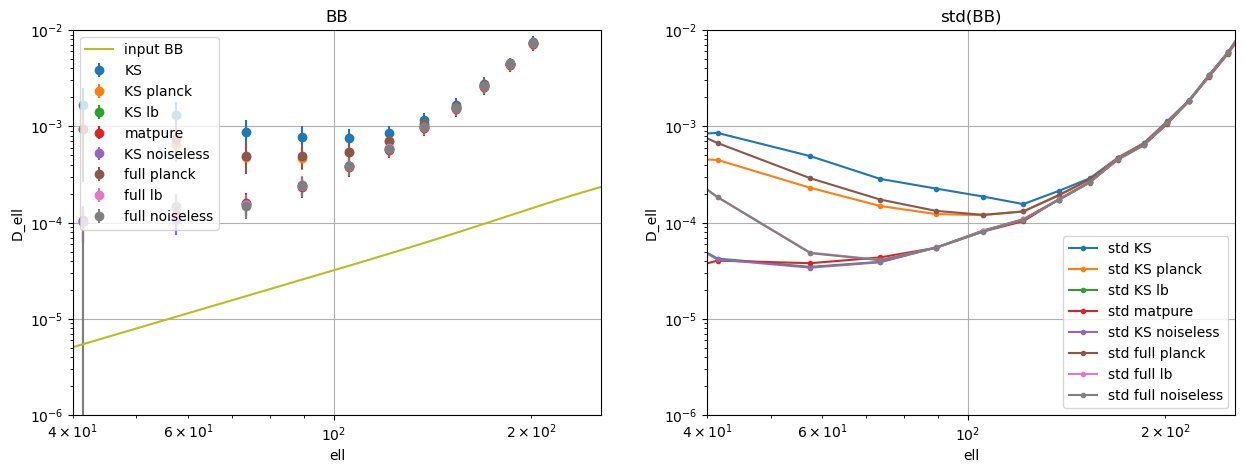

In [27]:
### nu_l = (2*l+1)*fsky*w2**2/w4*bin_size*fl
# knox = (bpw@input_cls[2] + mean_nl) * np.sqrt(2/(bpw@nu_l))
# # knox = (bpw@input_cls[2]) * np.sqrt(2/(bpw@nu_l))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# axes[0].errorbar(ells, mean, yerr=std, fmt='o', label='pcl')
axes[0].errorbar(ells, mean_KS, yerr=std_KS, fmt='o', label='KS')
axes[0].errorbar(ells, mean_KS_planck, yerr=std_KS_planck, fmt='o', label='KS planck')
axes[0].errorbar(ells, mean_KS_lb, yerr=std_KS_lb, fmt='o', label='KS lb')
axes[0].errorbar(ells, mean_matpure, yerr=std_matpure, fmt='o', label='matpure')
axes[0].errorbar(ells, mean_KS_noiseless, yerr=std_KS_noiseless, fmt='o', label='KS noiseless')
axes[0].errorbar(ells, mean_full_planck, yerr=std_full_planck, fmt='o', label='full planck')
axes[0].errorbar(ells, mean_full_lb, yerr=std_full_lb, fmt='o', label='full lb')
axes[0].errorbar(ells, mean_full_noiseless, yerr=std_full_noiseless, fmt='o', label='full noiseless')

# axes[0].plot(c2d*s4, label='nl_s4')
# axes[0].errorbar(ells, c2db*mean_nl_KS, yerr=c2db*std_nl_KS, fmt='.', label='Nl_bb_KS')
# axes[0].errorbar(ells, c2db*mean_nl_pure, yerr=c2db*std_nl_pure, fmt='.', label='Nl_bb_pure')


# axes[0].plot(c2d*cl_noise_pure_pol[3], label='residual noise matpure', linestyle='dashed')
# axes[0].plot(c2d*cl_noise_KS_pol[3], label='residual noise KS', linestyle='dashed')
# axes[0].plot(c2d*cl_noise_scalar, label='residual noise scalar', linestyle='dashed')
axes[0].plot(c2d*input_cls[2], label='input BB')
axes[0].set_title('BB')
# axes[0].set_ylim([1e-5, 1e-1])

# axes[1].plot(ells, std, marker='.',label='std pcl')
axes[1].plot(ells, std_KS, marker='.',label='std KS')
axes[1].plot(ells, std_KS_planck, marker='.',label='std KS planck')
axes[1].plot(ells, std_KS_lb, marker='.',label='std KS lb')
axes[1].plot(ells, std_matpure, marker='.',label='std matpure')
axes[1].plot(ells, std_KS_noiseless, marker='.',label='std KS noiseless')
axes[1].plot(ells, std_full_planck, marker='.',label='std full planck')
axes[1].plot(ells, std_full_lb, marker='.',label='std full lb')
axes[1].plot(ells, std_full_noiseless, marker='.',label='std full noiseless')

# axes[1].plot(ells, c2db*knox, label='knox')
axes[1].set_title('std(BB)')
# axes[1].set_ylim([1e-8, 1e-6])

for ax in axes.flatten():
    ax.legend()
    ax.set_xlim([40, 2*nside])
    ax.set_ylim([1e-6, 1e-2])
    ax.loglog()
    ax.grid()
    ax.set_xlabel('ell')
    ax.set_ylabel('D_ell')

In [15]:
# input_cls = mylib.get_camb(0, 0, lmax) 

# nside=128
# sigmab = hp.nside2resol(nside) 
# fwhm = (8*np.log(2))**0.5 * sigmab 
# # fwhm = hp.nside2resol(nside) 

# np.random.seed(0)
# m = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
# bb = hp.alm2map(hp.map2alm(m)[2], nside)
# # hp.mollview(bb)
# hp.gnomview(bb, rot=(40,-42), reso=25)

In [16]:
# cl_r1 = mylib.get_camb(0, 1, lmax) 

In [17]:
# ell_min = 50
# ell_max = 2*nside
# inds = (ells >=ell_min) & (ells <= ell_max)

# sigma_r_KS = np.zeros(nmc)
# sigma_r_matpure = np.zeros(nmc)
# sigma_r_KS_planck = np.zeros(nmc)
# sigma_r_KS_lb = np.zeros(nmc)
# sigma_r_KS_noiseless = np.zeros(nmc)
# sigma_r_full_planck = np.zeros(nmc)
# sigma_r_full_lb = np.zeros(nmc)
# sigma_r_full_noiseless = np.zeros(nmc)

# for i in range(nmc):
#     sigma_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS[i][inds])**2 )) 
#     sigma_r_KS_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS_planck[i][inds])**2 )) 
#     sigma_r_KS_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS_lb[i][inds])**2 ))     
#     sigma_r_matpure[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_pure@cl_r1[2])[inds] / cl_matpure[i][inds])**2 ))     
#     sigma_r_KS_noiseless[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_KS@cl_r1[2])[inds] / cl_KS_noiseless[i][inds])**2 )) 
#     sigma_r_full_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_scalar@cl_r1[2])[inds] / cl_full_planck[i][inds])**2 )) 
#     sigma_r_full_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_scalar@cl_r1[2])[inds] / cl_full_lb[i][inds])**2 ))     
#     sigma_r_full_noiseless[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * ( (bpw_scalar@cl_r1[2])[inds] / cl_full_noiseless[i][inds])**2 ))

In [18]:
# plt.figure(figsize=(8,5))
# plt.hist(sigma_r_KS, label=f'KS {1e3*np.mean(sigma_r_KS):.5f}', alpha=0.75, edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_KS_planck, label=f'KS planck {1e3*np.mean(sigma_r_KS_planck):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_full_planck, label=f'full planck {1e3*np.mean(sigma_r_full_planck):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_KS_lb, label=f'KS lb {1e3*np.mean(sigma_r_KS_lb):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_full_lb, label=f'full lb {1e3*np.mean(sigma_r_full_lb):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_KS_noiseless, label=f'KS noiseless {1e3*np.mean(sigma_r_KS_noiseless):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_full_noiseless, label=f'full noiseless {1e3*np.mean(sigma_r_full_noiseless):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_matpure, label=f'matpure {1e3*np.mean(sigma_r_matpure):.5f}', alpha=0.75,edgecolor='black', linewidth=0.5)

# plt.legend()
# plt.grid()
# plt.xlabel('sigma(r)')
# plt.ylabel('# MC')
# plt.semilogx()

In [19]:
# np.abs(np.mean(sigma_r_KS_planck) - np.mean(sigma_r_KS)) / np.mean(sigma_r_KS) * 100

In [20]:
# np.abs(np.mean(sigma_r_KS_lb) - np.mean(sigma_r_KS)) / np.mean(sigma_r_KS) * 100

In [21]:
# np.abs(np.mean(sigma_r_matpure) - np.mean(sigma_r_KS)) / np.mean(sigma_r_KS) * 100